In [1]:
from dataset_loader import METRLADatasetLoader

loader = METRLADatasetLoader()
dataset = loader.get_dataset()

In [2]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [3]:
import numpy as np

In [4]:
adj_mat = np.array([[0.0 for i in range(dataset[0].x.shape[0])] for j in range(dataset[0].x.shape[0])]) # 207x207 matrix for representing connections between each of the 207 sensors (nodes)

edge_attr = np.array(dataset[0].edge_attr) # array of edge attributes for each edge by index
src = np.array(dataset[0].edge_index[0]) # array of source nodes for each edge by index
dest = np.array(dataset[0].edge_index[1]) # array of destination nodes for each edge by index

for edge_index in range(len(edge_attr)):
    adj_mat[src[edge_index]][dest[edge_index]] = edge_attr[edge_index]

for edge_index in range(len(edge_attr)):
    if adj_mat[dest[edge_index]][src[edge_index]] == 0.0:
        adj_mat[dest[edge_index]][src[edge_index]] = edge_attr[edge_index]

In [5]:
import collections
import pandas as pd

In [6]:
def create_corr_matrices(snapshot):
    dict_speed = collections.defaultdict(list)
    dict_density = collections.defaultdict(list)

    for index, sensor in enumerate(snapshot.x):
        dict_speed[index] = np.array(sensor[0])
        dict_density[index] = np.array(sensor[1])

    df_speed = pd.DataFrame(dict_speed)
    df_density = pd.DataFrame(dict_density)

    # Calculate the correlation matrices
    corr_speed = df_speed.corr(method = "spearman")
    corr_density = df_density.corr(method = "spearman")

    return corr_speed, corr_density

In [7]:
# Function to calculate correlation between two nodes using adjacency matrix
def calculate_correlation(node1, node2, corr_mat):
    return corr_mat[node1][node2] * ( adj_mat[node1][node2] )

# Function to grow subgraph using BFS
def grow_subgraph(start_node, unvisited_nodes, adj_mat, speed_corr_mat, speed_threshold, density_corr_mat, density_threshold):
    subgraph = set()
    queue = [start_node]

    while queue:
        current_node = queue.pop(0)

        if current_node not in subgraph:
            subgraph.add(current_node)
            neighbors = [dest_node for dest_node in unvisited_nodes if adj_mat[current_node][dest_node] > 0 and dest_node != current_node]
            
            for neighbor in neighbors:
                speed_correlation = calculate_correlation(current_node, neighbor, speed_corr_mat)
                if np.isnan(speed_correlation):
                    speed_correlation = 0.0
                density_correlation = calculate_correlation(current_node, neighbor, density_corr_mat)
                if np.isnan(density_correlation):
                    density_correlation = 0.0
                
                if speed_correlation >= speed_threshold and density_correlation >= density_threshold:
                    queue.append(neighbor)

    return subgraph

In [8]:
def create_subgraphs(snapshot, speed_correlation_threshold, density_correlation_threshold):
    # Create a list to keep track of nodes that are already part of a subgraph
    unvisited_nodes = set(range(dataset[0].x.shape[0]))

    # Initialize an empty list to store the subgraphs
    subgraphs = []

    # Iterate through unvisited nodes to grow subgraphs
    while unvisited_nodes:
        node = unvisited_nodes.pop()

        spearman_speed, spearman_density = create_corr_matrices(snapshot)
        subgraph = grow_subgraph(node, unvisited_nodes, adj_mat, spearman_speed, speed_correlation_threshold, spearman_density, density_correlation_threshold)
        subgraphs.append(subgraph)
        
        unvisited_nodes = unvisited_nodes.difference(subgraph)

    return subgraphs

In [9]:
# Set correlation thresholds for subgraph growth
speed_correlation_threshold = 0.2  # Adjust as needed
density_correlation_threshold = 0.0  # Adjust as needed

subgraphs = create_subgraphs(train_dataset[1255], speed_correlation_threshold, density_correlation_threshold)

# Print the resulting subgraphs
for index, subgraph in enumerate(subgraphs):
    print(f"Subgraph {index + 1}: {subgraph}")

Subgraph 1: {0, 67, 36, 37, 199, 140, 13, 142, 111, 143, 145, 114, 115, 116, 109, 54, 51, 58}
Subgraph 2: {1, 135, 177, 184, 123}
Subgraph 3: {2, 132, 7, 11, 152, 28, 167, 178, 53, 55, 183, 201, 78, 79, 85, 105, 106, 107, 110}
Subgraph 4: {192, 3, 5}
Subgraph 5: {33, 4, 6, 15}
Subgraph 6: {8, 185}
Subgraph 7: {9}
Subgraph 8: {10, 156}
Subgraph 9: {128, 12, 17, 20, 22, 154, 155, 157, 159, 160, 161, 162, 163, 32, 40, 176, 187, 188, 191, 193, 195, 68, 198, 70, 206, 80, 83, 90, 96, 97, 98, 102, 103, 122, 127}
Subgraph 10: {130, 131, 137, 141, 14, 146, 150, 151, 158, 164, 41, 43, 47, 52, 60, 190, 63, 69, 71, 72, 73, 75, 204, 77, 76, 81, 82, 84, 87, 88, 113}
Subgraph 11: {101, 166, 133, 134, 138, 16, 29}
Subgraph 12: {18, 35}
Subgraph 13: {39, 74, 175, 19, 119, 57, 94}
Subgraph 14: {200, 121, 50, 21}
Subgraph 15: {165, 174, 23}
Subgraph 16: {168, 169, 42, 171, 173, 24, 62}
Subgraph 17: {129, 49}
Subgraph 18: {136}
Subgraph 19: {139}
Subgraph 20: {144, 91, 93}
Subgraph 21: {147}
Subgraph 22: 

In [10]:
def create_subgraph_corr_matrices(subgraphs, snapshot):
    dict_speed = collections.defaultdict(list)
    dict_density = collections.defaultdict(list)

    for index, subgraph in enumerate(subgraphs):
        dict_speed[index] = np.array([np.mean(np.array([train_dataset[1255].x[sensor][0][timestep] for sensor in subgraph])) for timestep in range(dataset[0].x.shape[2])])
        dict_density[index] = np.array([np.mean(np.array([train_dataset[1255].x[sensor][1][timestep] for sensor in subgraph])) for timestep in range(dataset[0].x.shape[2])])

    df_speed = pd.DataFrame(dict_speed)
    df_density = pd.DataFrame(dict_density)

    corr_speed = df_speed.corr()
    corr_density = df_density.corr()

    return corr_speed, corr_density

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

In [12]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=16,
                           periods=periods,
                           improved=True)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(16, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [13]:
# device support
device = torch.device('cuda') # cpu for cpu, cuda for gpu
subset = 500 # subset of train dataset for training on weaker devices
epochs = 20
iterations = 5

In [14]:
# import random
# import gc # garbage collector

In [16]:
model_speed = TemporalGNN(node_features=2, periods=12).to(device)
model_density = TemporalGNN(node_features=2, periods=12).to(device)
optimizer_speed = torch.optim.Adam(model_speed.parameters(), lr=0.01)
optimizer_density = torch.optim.Adam(model_density.parameters(), lr=0.01)
model_speed.train()
model_density.train()

# gc.collect()
# torch.cuda.empty_cache()

print("Running training...")
for iteration in range(iterations):
    for epoch in range(epochs):
        loss_speed = 0
        loss_density = 0
        for step in range(subset):
            # snapshot = train_dataset[step].to(device)
            snapshot = train_dataset[((iteration * subset) + step) % train_dataset.snapshot_count].to(device) # shift snapshot subset every iteration
            # snapshot = train_dataset[random.randrange(train_dataset.snapshot_count)].to(device) # random snapshot
            # Get model predictions
            y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
            y_hat_density = model_density(snapshot.x, snapshot.edge_index)
            # Mean squared error
            loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
            loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)

        loss_speed = loss_speed / (step + 1)
        loss_density = loss_density / (step + 1)
        loss_speed.backward()
        loss_density.backward()
        optimizer_speed.step()
        optimizer_speed.zero_grad()
        optimizer_density.step()
        optimizer_density.zero_grad()
        print("Epoch speed {} train MSE: {:.4f}".format(iteration * epochs + epoch + 1, loss_speed.item()))
        print("Epoch density {} train MSE: {:.4f}".format(iteration * epochs + epoch + 1, loss_density.item()))

        # gc.collect()
        # torch.cuda.empty_cache()


Running training...
Epoch speed 1 train MSE: 0.8187
Epoch density 1 train MSE: 0.8502
Epoch speed 2 train MSE: 0.8063
Epoch density 2 train MSE: 0.8278
Epoch speed 3 train MSE: 0.7951
Epoch density 3 train MSE: 0.8068
Epoch speed 4 train MSE: 0.7844
Epoch density 4 train MSE: 0.7840
Epoch speed 5 train MSE: 0.7730
Epoch density 5 train MSE: 0.7578
Epoch speed 6 train MSE: 0.7605
Epoch density 6 train MSE: 0.7275
Epoch speed 7 train MSE: 0.7467
Epoch density 7 train MSE: 0.6932
Epoch speed 8 train MSE: 0.7315
Epoch density 8 train MSE: 0.6555
Epoch speed 9 train MSE: 0.7153
Epoch density 9 train MSE: 0.6151
Epoch speed 10 train MSE: 0.6984
Epoch density 10 train MSE: 0.5728
Epoch speed 11 train MSE: 0.6816
Epoch density 11 train MSE: 0.5294
Epoch speed 12 train MSE: 0.6654
Epoch density 12 train MSE: 0.4859
Epoch speed 13 train MSE: 0.6500
Epoch density 13 train MSE: 0.4433
Epoch speed 14 train MSE: 0.6357
Epoch density 14 train MSE: 0.4025
Epoch speed 15 train MSE: 0.6222
Epoch density

In [15]:
import pickle

In [18]:
# save the speed model as a pickle file
model_pkl_file = "./traffic_prediction_speed_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_speed, file)

In [19]:
# save the density model as a pickle file
model_pkl_file = "./traffic_prediction_density_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_density, file)

In [16]:
# load the speed model from the pickle file
model_pkl_file = "./traffic_prediction_speed_model.pkl"
model_speed = pickle.load(open(model_pkl_file, 'rb'))

In [17]:
# load the density model from the pickle file
model_pkl_file = "./traffic_prediction_density_model.pkl"
model_density = pickle.load(open(model_pkl_file, 'rb'))

In [18]:
horizon = 300
hour = 1255
sensor = 13
timestep = 0

In [39]:
model_speed.eval()
model_density.eval()
loss_speed = 0
loss_density = 0

# Store for analysis
predictions_speed = []
labels_speed = []
predictions_density = []
labels_density = []
anomalies_speed = [test_dataset[hour + i].y.permute(1, 0, 2)[0] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph
anomalies_density = [test_dataset[hour + i].y.permute(1, 0, 2)[1] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph

# gc.collect()
# torch.cuda.empty_cache()

for step in range(horizon):
    snapshot = test_dataset[hour + step].to(device)

    # Get predictions
    y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
    y_hat_density = model_density(snapshot.x, snapshot.edge_index)

    # Mean squared error
    loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0]) ** 2)
    loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1]) ** 2)

    if step > 1:
        # acceleration or deviation
        acc_speed = torch.mean(abs((y_hat_speed - predictions_speed[-1]) / predictions_speed[-1]))
        if acc_speed > 1: # random value for now
            anomalies_speed[step] = y_hat_speed # mark point on predicted graph if it exceeds some threshold of acceleration
        acc_density = torch.mean(abs((y_hat_density - predictions_density[-1]) / predictions_density[-1]))
        if acc_density > 1: # random value for now
            anomalies_density[step] = y_hat_density # mark point on predicted graph if it exceeds some threshold of acceleration

    labels_speed.append(snapshot.y.permute(1, 0, 2)[0])
    labels_density.append(snapshot.y.permute(1, 0, 2)[1])
    predictions_speed.append(y_hat_speed)
    predictions_density.append(y_hat_density)

    # gc.collect()
    # torch.cuda.empty_cache()

loss_speed = loss_speed / (step + 1)
loss_speed = loss_speed.item()
loss_density = loss_density / (step + 1)
loss_density = loss_density.item()

print("Test speed MSE: {:.4f}".format(loss_speed))
print("Test density MSE: {:.4f}".format(loss_density))

Test speed MSE: 0.7385
Test density MSE: 0.5889


In [21]:
speed_preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_speed])
speed_labels  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_speed])
speed_anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_speed])
density_preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_density])
density_labels  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_density])
density_anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_density])

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

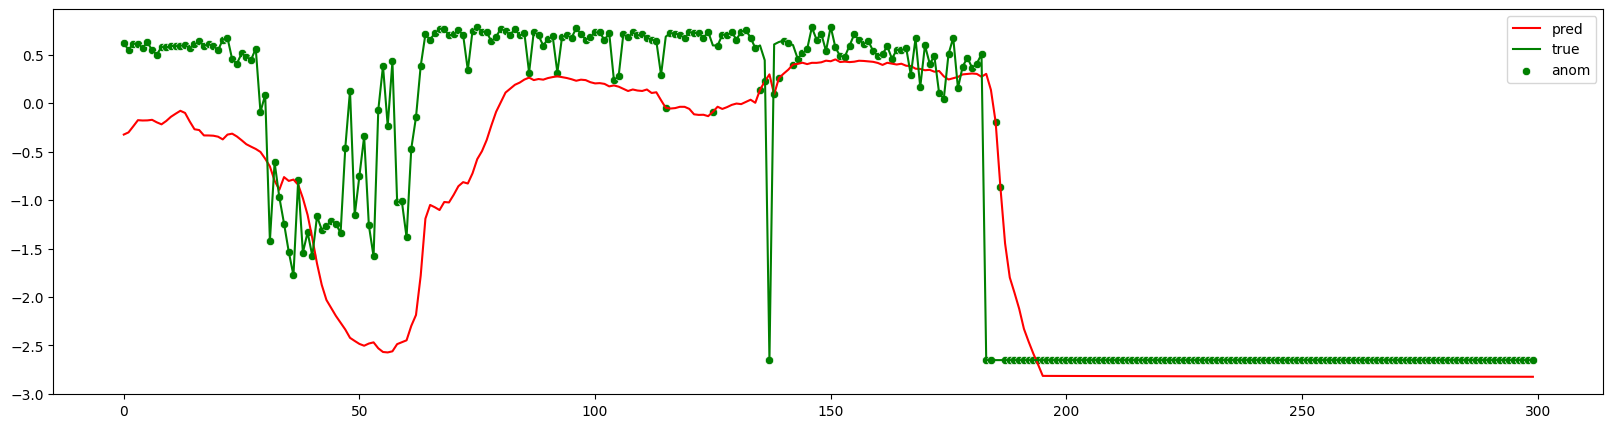

In [23]:
plt.figure(figsize=(20,5))
sns.lineplot(data=speed_preds, label="pred", color='red')
sns.lineplot(data=speed_labels, label="true", color='green')
sns.scatterplot(data=speed_anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

<Axes: >

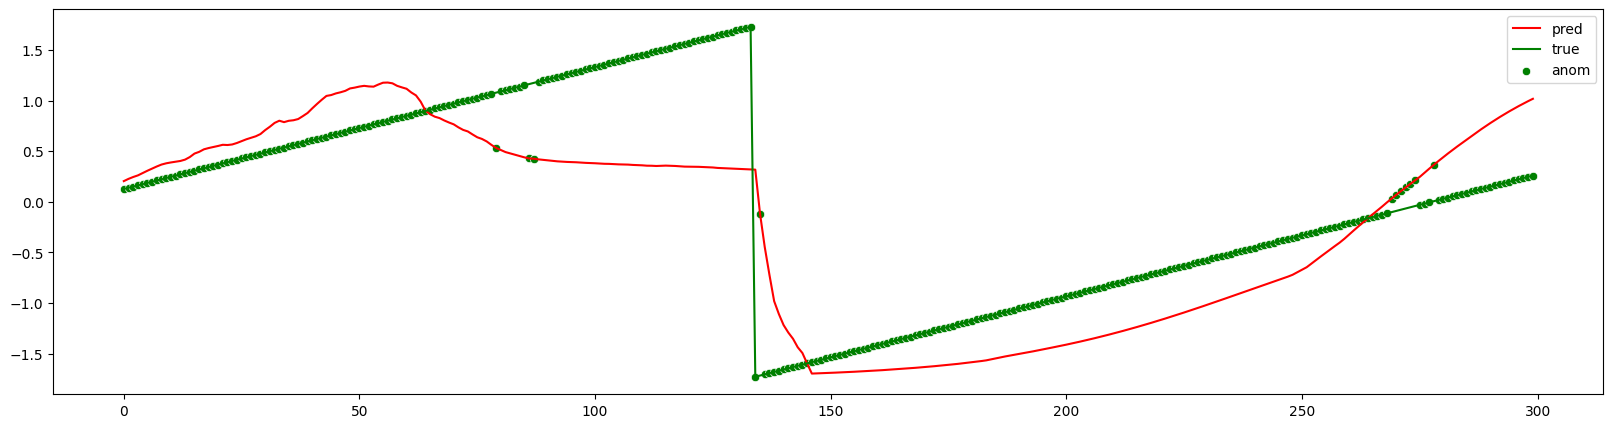

In [24]:
plt.figure(figsize=(20,5))
sns.lineplot(data=density_preds, label="pred", color='red')
sns.lineplot(data=density_labels, label="true", color='green')
sns.scatterplot(data=density_anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

In [25]:
def subgraph_anomaly_detection(subgraph, prev_hour, curr_hour):
    #cur_hour -> prev_hour, pred_hour -> curr_hour
    #dimensions: subgraph-set, curr_hour-snapshot of graph during current hour (207x2x12), pred_hour-model predicted snapshot of graph for the next hour (207x12)

    prev_pred_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(prev_hour[sensor][timestep])
        prev_pred_means.append(np.mean(temp))

    base = np.mean(prev_pred_means)
    dev = np.std(prev_pred_means)

    cur_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(curr_hour[sensor][0][timestep])
        cur_means.append(np.mean(temp))

    anoms = []
    for i in cur_means:
        anoms.append(max(0.0, abs(i - base) - dev))

    return anoms

In [26]:
def find_all_subgraph_anomalies(subgraphs, curr_hour, pred_hour):
    anomaly_list = []
    norm_anomaly_list = []
    mean_anomaly_dict = {}
    max_val = 0.0
    for index, subgraph in enumerate(subgraphs):
        ans = subgraph_anomaly_detection(subgraph, curr_hour, pred_hour)
        anomaly_list.append(ans)
        max_val = max(max_val,max(ans))

    for index, anom in enumerate(anomaly_list):
        temp = 0.0
        count = 0
        if(max_val==0):
            norm_anoms = anom
        else:
            norm_anoms = [x/max_val for x in anom]
        norm_anomaly_list.append(norm_anoms)

        for i in norm_anoms:
            if i > 0:
                temp += i
                count += 1
        if(count == 0):
            mean_anomaly_dict[index] = temp
        else:
            mean_anomaly_dict[index] = temp / count

    return (norm_anomaly_list, mean_anomaly_dict)

In [27]:
def top_k_anomalous_subgraphs(k, mean_anomaly_dict):
    sorted_mean_anomaly_dict = sorted(mean_anomaly_dict.items(), key = lambda x : x[1], reverse = True)
    top_k_anomaly = [x for x, y in sorted_mean_anomaly_dict]
    return top_k_anomaly[0 : k]

In [28]:
def micro_feature_analysis(anomalous_subgraphs, curr_hour, pred_hour):
    anomalous_analysis = {}
    for anomalous_subgraph in anomalous_subgraphs:
        anomalous_analysis[anomalous_subgraph] = {}
        for node in subgraphs[anomalous_subgraph]:
            anomalous_analysis[anomalous_subgraph][node] = []
            curr_hour_node_values = [float(x) for x in curr_hour[node][0]]
            curr_hour_node_mean = np.mean(curr_hour_node_values)
            curr_hour_node_dev = np.std(curr_hour_node_values)
            pred_hour_node_values = [float(x) for x in pred_hour[node]]

            for step in range(len(pred_hour[0])): #the range is basically how many timesteps, which is 12 here
                anom = max(0.0, abs(pred_hour[node][step] - curr_hour_node_mean) - 2 * curr_hour_node_dev)
                if(anom):
                    anomalous_analysis[anomalous_subgraph][node].append(step)

    return anomalous_analysis

In [29]:
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [30]:
def prediction_based_anomaly(next_real_values, next_predictions, previous_real_values, previous_predictions, node):
    # Calculate the residuals for the previous and next 12 timesteps
    previous_residuals = np.array(previous_predictions[node]) - np.array(previous_real_values[node])
    next_residuals = np.array(next_predictions[node]) - np.array(next_real_values[node])

    # Calculate z-scores for the residuals of the previous 12 timesteps
    z_scores_previous = zscore(previous_residuals)

    # Define a threshold for anomaly detection based on the z-scores of the previous residuals
    anomaly_threshold = np.mean(np.abs(z_scores_previous))

    # Calculate z-scores for the residuals of the next 12 timesteps
    z_scores_next = zscore(next_residuals)

    # Identify anomalies in the residuals of the next 12 timesteps
    anomalies = np.where(np.abs(z_scores_next) > anomaly_threshold)[0]

    return anomalies

In [31]:
from sklearn.cluster import KMeans

In [ ]:
subgraph_means = {}

for index, subgraph in enumerate(subgraphs):
    node_speeds = []
    for node in subgraph:
        node_speeds.append(torch.mean(train_dataset[9231].x[node][0]))
        
    subgraph_means[index] = np.mean(node_speeds)


# subgraph_means_pd = pd.DataFrame(subgraph_means)    
k_values = range(1, 30)
inertias = []
feature_list = list(subgraph_means.values())

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    #feature_list = list(subgraph_means.values())
    kmeans.fit(np.array(feature_list).reshape(-1, 1))  # X is your data
    inertias.append(kmeans.inertia_)
    
diff1 = np.diff(inertias)
diff2 = np.diff(diff1)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

elbow_point = np.where(diff2 == max(diff2))[0][0] + 2

print("Elbow point is ", elbow_point)
kmeans = KMeans(n_clusters=elbow_point, random_state=0)
kmeans.fit(np.array(feature_list).reshape(-1, 1))
cluster_labels = kmeans.labels_
print("cluster assignments are ,",  cluster_labels)

import matplotlib.pyplot as plt
#Initialize lists to store data points for each cluster
cluster_data = [[] for _ in range(elbow_point)]

# Organize data points by cluster
for i, label in enumerate(cluster_labels):
    if label == cluster:
        cluster_data[label].append(feature_values[i])
# Plot the data points colored by their cluster assignment
for cluster in range(elbow_point):
    plt.scatter(cluster_data[cluster], [cluster] * np.sum(cluster_labels == cluster), label=f'Cluster {cluster}')

plt.xlabel('Feature Value')
plt.ylabel('Cluster')
plt.legend()
plt.title('K-means Clustering with a Single Feature')
plt.show()

In [56]:
import random
import copy

In [80]:
injected_hours_population = range(12, 500)
injected_hour_count = 100
k = 5

speed_correlation_threshold = 0.2  # Adjust as needed
density_correlation_threshold = 0.0  # Adjust as needed


### Injection method 1
- only macro detection
- 1 random node selected per hour
- entire hour injected for the randomly selected hours

In [71]:
injected_dataset = copy.deepcopy(test_dataset)
injected_dict = {}
injected_hours = random.sample(injected_hours_population, injected_hour_count) # injecting into 100 random hours in the first 2000 hours

for i in range(injected_hour_count):
    injected_node = random.randrange(0, 207) # selecting 1 random node every injected hour
    injected_dict[injected_hours[i]] = injected_node
    anomaly_vals = [random.uniform(-2.3, -2.6522) for i in range(12)] # injecting the complete hour
    injected_dataset[injected_hours[i]].x[injected_node][0] = torch.tensor(anomaly_vals)

macro_prob = 0

for hour in injected_hours_population:
    subgraphs = create_subgraphs(injected_dataset[hour], speed_correlation_threshold, density_correlation_threshold)

    injected_test_snapshot = injected_dataset[hour].to(device)
    prev_injected_test_snapshot = injected_dataset[hour - 12].to(device)
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).cpu().detach().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).cpu().detach().numpy()

    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x.cpu())
    anomalous_subgraphs = top_k_anomalous_subgraphs(k, mean_anomaly_dict)

    anom_node_list = []
    if hour in injected_dict:
        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list.append(node) # list of all nodes in every anomalous subgraph for the current hour
        if(injected_dict[hour] in anom_node_list):
            macro_prob += 1

print(macro_prob / injected_hour_count)

0.53


### Injection method 2
- only macro detection
- random number of nodes selected per hour
  - need to count number of nodes injected over all hours to calculate probability
- entire hour injected for the randomly selected hours 

In [72]:
injected_dataset = copy.deepcopy(test_dataset)
injected_dict = {}
injected_hours = random.sample(injected_hours_population, injected_hour_count)

macro_prob = 0
count = 0

for hour in injected_hours_population:
    subgraphs = create_subgraphs(injected_dataset[hour], speed_correlation_threshold, density_correlation_threshold)

    if hour in injected_hours:
        injected_subgraph = random.randrange(0, len(subgraphs))
        # selecting a random number of random node every injected hour
        injected_nodes = random.sample(list(subgraphs[injected_subgraph]), random.randrange(1, len(subgraphs[injected_subgraph]) + 1))
        injected_dict[hour] = injected_nodes
        count += len(injected_nodes)
        for node in injected_nodes:
            anomaly_vals = [random.uniform(-2.3, -2.6522) for i in range(12)]
            injected_dataset[hour].x[node][0] = torch.tensor(anomaly_vals)

    injected_test_snapshot = injected_dataset[hour].to(device)
    prev_injected_test_snapshot = injected_dataset[hour - 12].to(device)
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).cpu().detach().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).cpu().detach().numpy()

    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x.cpu())
    anomalous_subgraphs = top_k_anomalous_subgraphs(k, mean_anomaly_dict)

    anom_node_list = []
    # Bro, this is for macro feature anomaly detection accuracy? Sure, lets go with that
    if hour in injected_dict:
        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list.append(node)
        for anom_node in injected_dict[hour]:
            if anom_node in anom_node_list:
                macro_prob += 1

print(macro_prob / count)

0.715625


### Injection method 3
- macro and first micro detection
- random number of nodes selected per hour
  - need to count number of nodes injected over all hours to calculate probability
- entire hour injected for the randomly selected hours 

In [73]:
injected_dataset = copy.deepcopy(test_dataset)
injected_dict = {}
injected_hours = random.sample(injected_hours_population, injected_hour_count)

macro_prob = 0
micro_prob = 0
count = 0

for hour in injected_hours_population:
    subgraphs = create_subgraphs(injected_dataset[hour], speed_correlation_threshold, density_correlation_threshold)

    if hour in injected_hours:
        injected_subgraph = random.randrange(0, len(subgraphs))
        injected_nodes = random.sample(list(subgraphs[injected_subgraph]), random.randrange(1, len(subgraphs[injected_subgraph]) + 1))
        injected_dict[hour] = injected_nodes
        count += len(injected_nodes)
        for node in injected_nodes:
            anomaly_vals = [random.uniform(-2.3, -2.6522) for i in range(12)]
            injected_dataset[hour].x[node][0] = torch.tensor(anomaly_vals)

    injected_test_snapshot = injected_dataset[hour].to(device)
    prev_injected_test_snapshot = injected_dataset[hour - 12].to(device)
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).cpu().detach().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).cpu().detach().numpy()

    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x.cpu())
    anomalous_subgraphs = top_k_anomalous_subgraphs(k, mean_anomaly_dict)

    anom_node_list_macro = []
    # Bro, this is for macro feature anomaly detection accuracy? Sure, lets go with that
    if hour in injected_dict:
        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list_macro.append(node)
        for anom_node in injected_dict[hour]:
            if anom_node in anom_node_list_macro:
                macro_prob += 1

    micro_res = {}
    anom_node_list_micro = []
    micro_res = micro_feature_analysis(anomalous_subgraphs, injected_test_snapshot.x.cpu(), predicted)

    if hour in injected_dict:
        for subgraph in micro_res:
            for node in micro_res[subgraph]:
                if(len(micro_res[subgraph][node])):
                    anom_node_list_micro.append(node)

        for anom_node in injected_dict[hour]:
            if anom_node in anom_node_list_micro:
                micro_prob += 1

print(macro_prob / count)
print(micro_prob / count)

0.9052631578947369
0.7543859649122807


### Injection method 4
- only first micro detection
- random number of nodes selected per hour
- random timesteps in selected in each of the randomly selected hours, such that the majority of that hour is anomalous
  - need to count number of timesteps for each node over every hour to calculate probability

In [82]:
injected_dataset = copy.deepcopy(test_dataset)
injected_dict = {}
injected_hours = random.sample(injected_hours_population, injected_hour_count)

micro_prob = 0
count = 0

k = 15

for hour in injected_hours_population:
    subgraphs = create_subgraphs(injected_dataset[hour], speed_correlation_threshold, density_correlation_threshold)
  
    if hour in injected_hours:
        injected_subgraph = random.randrange(0, len(subgraphs))
        injected_nodes = random.sample(list(subgraphs[injected_subgraph]), random.randrange(1, len(subgraphs[injected_subgraph]) + 1))
        injected_dict[hour] = {}

        for node in injected_nodes:
            injected_dict[hour][node] = []
            # injecting into a random number of timesteps for every injected hour
            injected_timesteps = random.sample(range(0, 12), random.randrange(6, 13))
            count += len(injected_timesteps)
            for timestep in injected_timesteps:
                injected_dataset[hour].x[node][0][timestep] = torch.tensor(random.uniform(-2.3, -2.6522))
                injected_dict[hour][node].append(timestep)

    injected_test_snapshot = injected_dataset[hour].to(device)
    prev_injected_test_snapshot = injected_dataset[hour - 12].to(device)
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).cpu().detach().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).cpu().detach().numpy()

    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x.cpu())
    anomalous_subgraphs = top_k_anomalous_subgraphs(k, mean_anomaly_dict)

    micro_res = {}
    anom_node_list_micro = {}
    micro_res = micro_feature_analysis(anomalous_subgraphs, injected_test_snapshot.x.cpu(), predicted)

    if hour in injected_dict:
        for subgraph in micro_res:
            for node in micro_res[subgraph]:
                if(len(micro_res[subgraph][node])):
                    anom_node_list_micro[node] = micro_res[subgraph][node]

        for anom_node in injected_dict[hour]:
            if anom_node in anom_node_list_micro:
                for timestep in injected_dict[hour][anom_node]:
                    if timestep in anom_node_list_micro[anom_node]:
                        micro_prob += 1

print(micro_prob / count)

0.25647451963241436


### Injection method 5
- only second micro detection
- random number of nodes selected per hour
- random timesteps in selected in each of the randomly selected hours, such that the majority of that hour is anomalous
  - need to count number of timesteps for each node over every hour to calculate probability

In [83]:
injected_dataset = copy.deepcopy(test_dataset)
injected_dict = {}
injected_hours = random.sample(injected_hours_population[12:], injected_hour_count)

micro_prob = 0
count = 0

k = 15

for hour in injected_hours_population[12:]:
    subgraphs = create_subgraphs(injected_dataset[hour], speed_correlation_threshold, density_correlation_threshold)

    if hour in injected_hours:
        injected_subgraph = random.randrange(0, len(subgraphs))
        injected_nodes = random.sample(list(subgraphs[injected_subgraph]), random.randrange(1, len(subgraphs[injected_subgraph]) + 1))
        injected_dict[hour] = {}

        for node in injected_nodes:
            injected_dict[hour][node] = []
            injected_timesteps = random.sample(range(0, 12), random.randrange(6, 13))
            count += len(injected_timesteps)
            for timestep in injected_timesteps:
                injected_dataset[hour].x[node][0][timestep] = torch.tensor(random.uniform(-2.3, -2.6522))
                injected_dict[hour][node].append(timestep)

    next_injected_test_snapshot = injected_dataset[hour]
    curr_injected_test_snapshot = injected_dataset[hour - 12].to(device)
    prev_injected_test_snapshot = injected_dataset[hour - 12 - 12].to(device)
    curr_prediction = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).cpu().detach().numpy()
    next_prediction = model_speed(curr_injected_test_snapshot.x, curr_injected_test_snapshot.edge_index).cpu().detach().numpy()

    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, curr_prediction, next_injected_test_snapshot.x)
    anomalous_subgraphs = top_k_anomalous_subgraphs(k, mean_anomaly_dict)

    anom_node_list_micro = {}

    if hour in injected_dict:
        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list_micro[node] = prediction_based_anomaly(next_injected_test_snapshot.x.permute(1, 0, 2)[0], next_prediction, curr_injected_test_snapshot.x.cpu().permute(1, 0, 2)[0], curr_prediction, node)

        for anom_node in injected_dict[hour]:
            if anom_node in anom_node_list_micro:
                for timestep in injected_dict[hour][anom_node]:
                    if timestep in anom_node_list_micro[anom_node]:
                        micro_prob += 1

print(micro_prob / count)

0.194293254164605
